#### Predecting Strikeouts

using xgboost modeling to predict strikeout rate

In [171]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import root_mean_squared_error
import os
import numpy as np

os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/Coding Projects/Hitting Analysis/data/')

data grabbed and pre cleaned from local sql server

In [172]:
strikeout = pd.read_csv('./full/strikeout.csv')
strikeout['next_k'] = strikeout.groupby('name')['k_pct'].shift(-1)
strikeout_train = strikeout[strikeout['pa'] > 70]
strikeout_train = strikeout_train[strikeout_train['season'] != 2023]
strikeout_train = strikeout_train[strikeout_train['next_k'].notna()]

#### xgboost

In [173]:
X = strikeout_train.drop(columns=['name', 'season', 'k_pct', 'pa', 'next_k', 'z_contact_pct','sweet_spot_pct', 'chase_value', 'swing_percent'])
y = strikeout_train['k_pct']

In [174]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=.1, shuffle=True, random_state=26)

In [175]:
model = xgb.XGBRegressor()
model = model.fit(xtrain, ytrain)

In [ ]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=500, cv=4, n_jobs=-1, verbose=0)
rnd_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(rnd_searcher.best_params_)

In [176]:
grid_search_params = {
    'learning_rate': [0.05, 0.1],   
    'max_leaves': [7, 8, 9],
    'min_child_weight': [9, 10, 11],      
    'subsample': [0,4, 0.45 ,0.5],           
    'colsample_bytree':[0.95, 1],     
    'early_stopping_rounds':[8, 9 , 10],
    'max_depth': [2, 3, 4]
}

In [177]:
opti = {'colsample_bytree': 1, 'early_stopping_rounds': 9, 'learning_rate': 0.1, 'max_depth': 3, 'max_leaves': 8, 'min_child_weight': 10, 'subsample': 0.45}

In [ ]:
grid_searcher = GridSearchCV(model, grid_search_params, cv=4, n_jobs=-1, verbose=4)
grid_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(grid_searcher.best_params_)

In [178]:
model = model.set_params(**opti)
model = model.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])

[0]	validation_0-rmse:0.06054
[1]	validation_0-rmse:0.05625
[2]	validation_0-rmse:0.05255
[3]	validation_0-rmse:0.04941
[4]	validation_0-rmse:0.04664
[5]	validation_0-rmse:0.04418
[6]	validation_0-rmse:0.04209
[7]	validation_0-rmse:0.04012
[8]	validation_0-rmse:0.03855
[9]	validation_0-rmse:0.03710
[10]	validation_0-rmse:0.03578
[11]	validation_0-rmse:0.03449
[12]	validation_0-rmse:0.03363
[13]	validation_0-rmse:0.03273
[14]	validation_0-rmse:0.03200
[15]	validation_0-rmse:0.03155
[16]	validation_0-rmse:0.03097
[17]	validation_0-rmse:0.03062
[18]	validation_0-rmse:0.03023
[19]	validation_0-rmse:0.02981
[20]	validation_0-rmse:0.02949
[21]	validation_0-rmse:0.02912
[22]	validation_0-rmse:0.02878
[23]	validation_0-rmse:0.02854
[24]	validation_0-rmse:0.02838
[25]	validation_0-rmse:0.02812
[26]	validation_0-rmse:0.02798
[27]	validation_0-rmse:0.02797
[28]	validation_0-rmse:0.02779
[29]	validation_0-rmse:0.02752
[30]	validation_0-rmse:0.02731
[31]	validation_0-rmse:0.02720
[32]	validation_0-

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

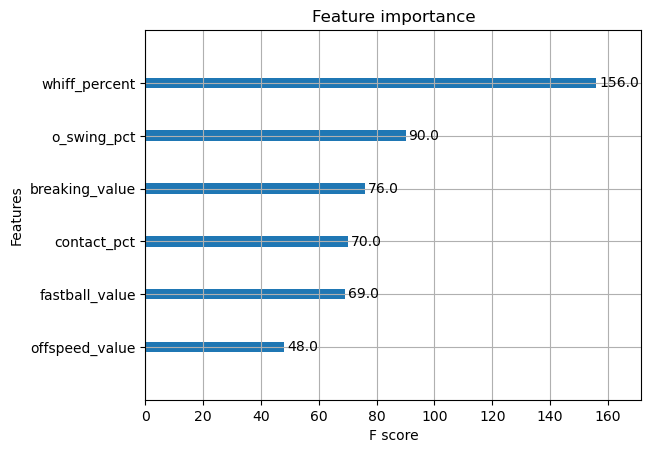

In [179]:
xgb.plot_importance(model)

In [180]:
predicted = model.predict(xtest)

#### Results

In [181]:
r = np.corrcoef(predicted, ytest.reset_index(drop=True))[0, 1]
print(r)

rmse = root_mean_squared_error(y_true=ytest, y_pred=predicted)
print(rmse)

0.91931952429905
0.025758431951730998


In [182]:
strikeout23 = strikeout[strikeout['season'] == 2023]
x_24 = strikeout23.drop(columns=['name', 'season', 'k_pct', 'pa', 'next_k', 'z_contact_pct','sweet_spot_pct', 'chase_value', 'swing_percent'])
strikeout23['pred_k'] = model.predict(x_24)
strikeout23 = strikeout23[['name','pa', 'season','k_pct', 'pred_k']]
strikeout23['diff'] = strikeout23['k_pct'] - strikeout23['pred_k']

C:\Users\dalto\AppData\Local\Temp\ipykernel_25616\2092766780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strikeout23['pred_k'] = model.predict(x_24)


In [183]:
strikeout24 = strikeout[strikeout['season'] == 2024]
x_25 = strikeout24.drop(columns=['name', 'season', 'k_pct', 'pa', 'next_k', 'z_contact_pct','sweet_spot_pct', 'chase_value', 'swing_percent'])
strikeout24['pred_k_24'] = model.predict(x_25)
strikeout24 = strikeout24[['name','pa', 'k_pct', 'pred_k_24']]
strikeout_23_24 = strikeout23.merge(strikeout24, on=['name'], how='outer')
strikeout_23_24 = strikeout_23_24.dropna()
strikeout_23_24 = strikeout_23_24[(strikeout_23_24['pa_y'] > 30) & (strikeout_23_24['pa_x'] > 30)]
print(f"corr between k% 23 and k% 24 {strikeout_23_24['k_pct_x'].corr(strikeout_23_24['k_pct_y'])}")
print(f"corr between pred k% 23 and k% 24 {strikeout_23_24['pred_k'].corr(strikeout_23_24['k_pct_y'])}")

corr between k% 23 and k% 24 0.7238891929862656
corr between pred k% 23 and k% 24 0.7322416010884177


C:\Users\dalto\AppData\Local\Temp\ipykernel_25616\2707437600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strikeout24['pred_k_24'] = model.predict(x_25)


#### Predecting 25

In [184]:
strikeout = pd.read_csv('./full/strikeout.csv')
strikeout['next_k'] = strikeout.groupby('name')['k_pct'].shift(-1)
strikeout_train = strikeout[strikeout['pa'] > 70]
strikeout_train = strikeout_train[strikeout_train['next_k'].notna()]
X = strikeout_train.drop(columns=['name', 'season', 'k_pct', 'pa', 'next_k', 'z_contact_pct','sweet_spot_pct', 'chase_value', 'swing_percent'])
y = strikeout_train['k_pct']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=.1, shuffle=True, random_state=26)


In [185]:
model = model.set_params(**opti)
model = model.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])

[0]	validation_0-rmse:0.06250
[1]	validation_0-rmse:0.05817
[2]	validation_0-rmse:0.05439
[3]	validation_0-rmse:0.05110
[4]	validation_0-rmse:0.04823
[5]	validation_0-rmse:0.04575
[6]	validation_0-rmse:0.04357
[7]	validation_0-rmse:0.04160
[8]	validation_0-rmse:0.04006
[9]	validation_0-rmse:0.03866
[10]	validation_0-rmse:0.03753
[11]	validation_0-rmse:0.03649
[12]	validation_0-rmse:0.03552
[13]	validation_0-rmse:0.03481
[14]	validation_0-rmse:0.03429
[15]	validation_0-rmse:0.03368
[16]	validation_0-rmse:0.03315
[17]	validation_0-rmse:0.03273
[18]	validation_0-rmse:0.03244
[19]	validation_0-rmse:0.03210
[20]	validation_0-rmse:0.03196
[21]	validation_0-rmse:0.03169
[22]	validation_0-rmse:0.03141
[23]	validation_0-rmse:0.03121
[24]	validation_0-rmse:0.03098
[25]	validation_0-rmse:0.03091
[26]	validation_0-rmse:0.03075
[27]	validation_0-rmse:0.03059
[28]	validation_0-rmse:0.03046
[29]	validation_0-rmse:0.03028
[30]	validation_0-rmse:0.03016
[31]	validation_0-rmse:0.03009
[32]	validation_0-

2025 data

In [186]:
plate_disc_25 = pd.read_csv('./full/plate_disc/merged_clean.csv')
x_25 = plate_disc_25[['O-Swing%', 'Swing%', 'Contact%', 'whiff_percent', 'chase_shadow_value', 'overall_value', 'breaking_value', 'fastball_value', 'offspeed_value']]
x_25 = x_25.rename(columns={'chase_shadow_value':'chase_value'})

In [187]:
x_25 = x_25.rename(columns={'Swing%': 'swing_percent', 'O-Swing%': 'o_swing_pct', 'Contact%': 'contact_pct'})
x_25 = x_25[x_24.columns]

In [188]:
plate_disc_25['proj_k%'] = model.predict(x_25)
plate_disc_25 = plate_disc_25[['Name', 'PA', 'proj_k%']]